In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller, pacf, acf, coint
from statsmodels.tsa.api import VAR
from tqdm import tqdm
from pymle.models import GeometricBM, OrnsteinUhlenbeck
from pymle.core.TransitionDensity import KesslerDensity, ShojiOzakiDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE
import aleatory
import aleatory.processes as an
from scipy.stats import norm
%matplotlib inline 

In [281]:
def load_data(file_path, delimiter=';'):
    """
    Loads CSV data.
    Assumes that the CSV has a header row.
    """
    df = pd.read_csv(file_path, delimiter=delimiter)
    # Ensure that the timestamp column is treated as a numeric (or datetime, if applicable)
    df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')
    return df

In [282]:
def compute_weighted_asset_series(df, asset, weight, time_col='timestamp', price_col='price'):
    """
    For a given asset, computes the average traded price per timestamp,
    multiplies it by the asset's weight and returns a series.
    """
    asset_df = df[df['symbol'] == asset]
    # Average price per timestamp – you may use other aggregation (e.g. volume-weighted average) if needed.
    avg_price = asset_df.groupby(time_col)[price_col].mean()
    return avg_price * weight

In [283]:
def compute_basket_price(df, basket_composition, time_col='timestamp', price_col='price'):
    """
    Computes a synthetic basket price time series by combining the underlying asset prices.
    basket_composition is a dictionary where the keys are asset names and the values are the weights.
    E.g. for PICNIC_BASKET1: {'CROISSANTS': 6, 'JAMS': 3, 'DJEMBES': 1}
    """
    basket_series = None
    # Loop through each asset in the basket composition
    for asset, weight in basket_composition.items():
        series = compute_weighted_asset_series(df, asset, weight, time_col, price_col)
        if basket_series is None:
            basket_series = series
        else:
            basket_series = basket_series.add(series, fill_value=0)
    basket_series.sort_index(inplace=True)
    return basket_series

In [284]:
def plot_time_series(series_dict, title='Time Series', xlabel='Timestamp', ylabel='Price'):
    """
    Plots multiple time series on the same figure.
    series_dict should be a dictionary with labels as keys and Pandas Series as values.
    """
    plt.figure(figsize=(12, 6))
    for label, series in series_dict.items():
        plt.plot(series.index, series.values, label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [285]:
def plot_spread_zscore(computed_basket, instrument_series, title='Spread and Z-Score'):
    """
    Computes and plots the spread between the computed basket price and the basket instrument price,
    and also computes the z-scores of the spread.
    
    This function generates two subplots in one window:
    1. The raw price spread.
    2. The z-score (standard deviations) of the spread.
    
    Parameters:
    - computed_basket: Pandas Series representing the computed basket price time series.
    - instrument_series: Pandas Series representing the traded basket instrument price time series.
    - title: Title for the overall figure.
    """
    # Align the two series based on their common timestamps.
    common_index = computed_basket.index.intersection(instrument_series.index)
    computed_common = computed_basket.loc[common_index]
    instrument_common = instrument_series.loc[common_index]
    
    # Compute the raw spread.
    spread = instrument_common - computed_common
    
    # Compute the mean and standard deviation, and then the z-scores.
    spread_mean = spread.mean()
    spread_std = spread.std()
    z_scores = (spread - spread_mean) / spread_std if spread_std != 0 else spread - spread_mean
    
    # Create two subplots: one for raw spread and one for z-scores.
    fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    ax[0].plot(common_index, spread, label='Raw Spread', color='blue')
    ax[0].set_title('Raw Price Spread')
    ax[0].set_ylabel('Price Difference')
    ax[0].legend()
    ax[0].grid(True)
    
    ax[1].plot(common_index, z_scores, label='Spread Z-Score', color='green')
    # Add a horizontal line at 0 for reference.
    ax[1].axhline(0, color='black', linestyle='--')
    ax[1].set_title('Spread Z-Score')
    ax[1].set_xlabel('Timestamp')
    ax[1].set_ylabel('Standard Deviations (Z-Score)')
    ax[1].legend()
    ax[1].grid(True)
    
    fig.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [286]:
def clustering_analysis(time_series, n_clusters=3):
    """
    Performs clustering on basket returns.
    Uses simple percentage change (returns) as features.
    Returns the cluster labels and displays a PCA plot.
    """
    # Compute returns (percentage change)
    returns = time_series.pct_change().dropna().values.reshape(-1, 1)
    
    # Clustering with KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(returns)
    
    # Use PCA for visualisation – here, just for demonstration with one feature.
    pca = PCA(n_components=1)
    components = pca.fit_transform(returns)
    
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(returns)), returns, c=clusters, cmap='viridis', label='Returns')
    plt.title('Clustering of Basket Returns')
    plt.xlabel('Time Index')
    plt.ylabel('Returns')
    plt.colorbar(label='Cluster')
    plt.show()
    
    return clusters

In [287]:
def linear_regression_analysis(computed_series, instrument_series, basket_name):
    """
    Performs and plots linear regression between computed and actual basket prices.
    """
    # Align the two series on their common timestamps AFTER getting them individually
    common_index = computed_series.index.intersection(instrument_series.index)

    if common_index.empty:
        print(f"No common timestamps found between computed and actual prices for {basket_name}. Cannot perform regression.")
        return
    if len(common_index) < 2:
         print(f"Not enough common data points ({len(common_index)}) for {basket_name} to perform regression.")
         return

    # Select data at common timestamps
    X_series = computed_series.loc[common_index]
    y_series = instrument_series.loc[common_index]

    # Reshape for sklearn
    X = X_series.values.reshape(-1, 1)
    y = y_series.values

    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    r2 = r2_score(y, y_pred)

    print(f"--- Linear Regression Results for {basket_name} ---")
    print(f"Coefficient (Slope): {model.coef_[0]:.4f}")
    print(f"Intercept: {model.intercept_:.4f}")
    print(f"R-squared: {r2:.4f}") # Goodness of fit
    print("-" * (30 + len(basket_name)))

    plt.figure(figsize=(12, 6))
    plt.scatter(X, y, label='Actual Data Points (Traded vs Computed)', alpha=0.5)
    plt.plot(X, y_pred, color='red', linewidth=2, label=f'Regression Line (R²={r2:.3f})')
    plt.xlabel('Computed Synthetic Basket Price')
    plt.ylabel('Actual Traded Basket Price')
    plt.title(f'Linear Regression: Actual vs. Computed Price for {basket_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [288]:
def get_pretty_ticks(spread_series, n_ticks=10):
    """
    Generates evenly spaced tick locations and formatted tick labels for a MultiIndex.
    """
    x = np.arange(len(spread_series))
    # Create tick locations (linearly spaced indices)
    if len(spread_series) > 1:
        tick_locs = np.linspace(0, len(spread_series) - 1, n_ticks, dtype=int)
    else:
        tick_locs = np.array([0])
    # Format tick labels
    tick_labels = [f"Day={spread_series.index[i][0]}, T={spread_series.index[i][1]}" for i in tick_locs]
    return x, tick_locs, tick_labels

def plot_spread_raw(spread_series, n_ticks=10):
    """
    Plots the raw spread in its own window with pretty x-axis tick labels.
    """
    x, tick_locs, tick_labels = get_pretty_ticks(spread_series, n_ticks)
    
    plt.figure(figsize=(14, 6))
    plt.plot(x, spread_series.values, label="Spread", color='blue')
    plt.xticks(tick_locs, tick_labels, rotation=45, ha='right')
    plt.title("Spread Over Time")
    plt.xlabel("Time (day, timestamp)")
    plt.ylabel("Spread")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_rolling_mean(spread_series, window=50, n_ticks=10):
    """
    Plots the rolling mean of the spread in its own window with pretty x-axis tick labels.
    """
    x, tick_locs, tick_labels = get_pretty_ticks(spread_series, n_ticks)
    rolling_mean = spread_series.rolling(window=window).mean()
    
    plt.figure(figsize=(14, 6))
    plt.plot(x, rolling_mean.values, label=f"Rolling Mean (window={window})", color='orange')
    plt.xticks(tick_locs, tick_labels, rotation=45, ha='right')
    plt.title("Rolling Mean of Spread")
    plt.xlabel("Time (day, timestamp)")
    plt.ylabel("Rolling Mean")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_rolling_std(spread_series, window=50, n_ticks=10):
    """
    Plots the rolling standard deviation of the spread in its own window with pretty x-axis tick labels.
    """
    x, tick_locs, tick_labels = get_pretty_ticks(spread_series, n_ticks)
    rolling_std = spread_series.rolling(window=window).std()
    
    plt.figure(figsize=(14, 6))
    plt.plot(x, rolling_std.values, label=f"Rolling Std (window={window})", color='green')
    plt.xticks(tick_locs, tick_labels, rotation=45, ha='right')
    plt.title("Rolling Standard Deviation of Spread")
    plt.xlabel("Time (day, timestamp)")
    plt.ylabel("Rolling Std Deviation")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [289]:
def hurst_exponent(ts):
    """Return the Hurst Exponent of the time series ts."""
    lags = range(2, min(100, len(ts)//2))
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return 2.0 * poly[0]

def rolling_zscore(series, window=50):
    rolling_mean = series.rolling(window).mean()
    rolling_std  = series.rolling(window).std()
    zscore = (series - rolling_mean) / rolling_std
    return zscore

def get_best_bid(row):
    # Gather bid prices from bid_price_1, bid_price_2, bid_price_3
    bid_prices = [row.get(f'bid_price_{i}', np.nan) for i in range(1, 4)]
    # Filter out any missing values (NaNs)
    valid_bids = [p for p in bid_prices if not pd.isna(p)]
    # Return the maximum valid bid, or NaN if none available
    return max(valid_bids) if valid_bids else np.nan

def get_best_ask(row):
    # Gather ask prices from ask_price_1, ask_price_2, ask_price_3
    ask_prices = [row.get(f'ask_price_{i}', np.nan) for i in range(1, 4)]
    # Filter out missing values
    valid_asks = [p for p in ask_prices if not pd.isna(p)]
    # Return the minimum valid ask, or NaN if none available
    return min(valid_asks) if valid_asks else np.nan

def calculate_spread(row):
    """
    Given a row of orderbook data, return the spread:
    Best Ask - Best Bid.
    If either is missing, return NaN.
    """
    best_bid = get_best_bid(row)
    best_ask = get_best_ask(row)
    if pd.isna(best_bid) or pd.isna(best_ask):
        return np.nan
    return best_ask - best_bid

def get_spread_series(df, product):
    """
    Filters the DataFrame for a given product, calculates the spread per row,
    constructs a combined 'time' index (day-timestamp), and returns the spread series.
    """
    sub = df[df['product'] == product].copy()
    # Calculate spread for each row.
    sub['spread'] = sub.apply(calculate_spread, axis=1)
    # Create a time key; you could also convert to datetime if preferred.
    sub['time'] = sub['day'].astype(str) + '-' + sub['timestamp'].astype(str)
    sub = sub.set_index('time')
    return sub['spread']

In [290]:
def get_best_bid_series(df, product):
    """
    For the given orderbook DataFrame (df) and product, extract rows,
    create a combined time key, calculate best bid using get_best_bid(),
    and return a Series indexed by time.
    """
    sub = df[df['product'] == product].copy()
    # Create a time key; if possible, you could convert this to a datetime or numeric value for better sorting.
    sub['time'] = sub['day'].astype(str) + '-' + sub['timestamp'].astype(str)
    sub = sub.sort_values(['day','timestamp'])  # Ensure chronological order.
    sub = sub.set_index('time')
    sub['best_bid'] = sub.apply(get_best_bid, axis=1)
    return sub['best_bid']

def get_best_ask_series(df, product):
    """
    For the given orderbook DataFrame (df) and product, extract rows,
    create a combined time key, calculate best ask using get_best_ask(),
    and return a Series indexed by time.
    """
    sub = df[df['product'] == product].copy()
    sub['time'] = sub['day'].astype(str) + '-' + sub['timestamp'].astype(str)
    sub = sub.sort_values(['day','timestamp'])
    sub = sub.set_index('time')
    sub['best_ask'] = sub.apply(get_best_ask, axis=1)
    return sub['best_ask']

def orderbook_histogram(df, product):
    product_df = df[df['product'] == product]
    columns_to_plot = ['bid_volume_1', 'bid_volume_2', 'bid_volume_3',
                       'ask_volume_1', 'ask_volume_2', 'ask_volume_3']
    num_plots = len(columns_to_plot)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols
    plt.figure(figsize=(12, 4 * num_rows))
    for i, column in enumerate(columns_to_plot, start=1):
        plt.subplot(num_rows, num_cols, i)
        volume_counts = product_df[column].value_counts()
        plt.bar(volume_counts.index.astype(str), volume_counts.values) # Convert index to string for plotting
        plt.title(f'{column} ({product})')
        plt.xlabel("Volume Level")
        plt.ylabel('Frequency')
        plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def get_instrument_price_series(df, instrument_name, time_col='timestamp', price_col='price'):
    """
    Extracts the average traded price time series for a given instrument.
    """
    instrument_df = df[df['symbol'] == instrument_name]
    # Calculate average traded price per timestamp
    avg_price_series = instrument_df.groupby(time_col)[price_col].mean()
    # Ensure series is sorted by time
    avg_price_series.sort_index(inplace=True)
    # Remove potential duplicate indices (e.g., if data had issues)
    avg_price_series = avg_price_series[~avg_price_series.index.duplicated(keep='first')]
    return avg_price_series

def multilinear_regression_analysis(X_df, y_series, analysis_title):
    """
    Performs multiple linear regression (y ~ X1 + X2 + ...) and plots results.
    Structured similarly to the original simple linear_regression_analysis function.

    Args:
        X_df (pd.DataFrame): DataFrame where columns are the independent variables (predictors).
                               Index should be alignable with y_series (e.g., timestamp).
        y_series (pd.Series): Series containing the dependent variable.
                                Index should be alignable with X_df.
        analysis_title (str): Title for the analysis output and plot.
    """
    # 1. Align Data: Combine predictors (X) and target (y) based on index.
    # Drop rows where *any* value is missing to ensure alignment.
    combined_df = pd.concat([y_series.rename('Y_DEPENDENT'), X_df], axis=1).dropna()

    # Check if enough data remains after alignment
    # Need more data points than predictors (number of columns in X_df)
    if combined_df.empty or len(combined_df) <= X_df.shape[1]:
        print(f"{analysis_title}: Not enough valid, aligned data points ({len(combined_df)}) for regression.")
        print(f"  (Requires > {X_df.shape[1]} points for {len(X_df.columns)} predictors)")
        return None # Indicate failure

    # Prepare final X (predictors) and y (target) from the aligned DataFrame
    X = combined_df[X_df.columns] # Select predictor columns using original names
    y = combined_df['Y_DEPENDENT']   # Select target column

    # 2. Fit the Multiple Linear Regression Model
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X) # Get predicted values

    # Calculate R-squared for model evaluation
    r2 = r2_score(y, y_pred)

    # 3. Print Results (similar structure to original function)
    print(f"--- {analysis_title} Results ---")
    # Try to use the original Series name if available, otherwise use generic 'Y'
    target_name = y_series.name if y_series.name else 'Y_DEPENDENT'
    print(f"Dependent Variable (y): {target_name}")
    print(f"Independent Variables (X): {', '.join(X.columns)}")
    print(f"Intercept: {model.intercept_:.4f}")
    print("Coefficients:")
    # Print each coefficient corresponding to its predictor column name
    for i, col in enumerate(X.columns):
        print(f"  {col}: {model.coef_[i]:.4f}")
    print(f"R-squared: {r2:.4f}")
    print("-" * (len(analysis_title) + 10))

    # 4. Plot (Actual vs. Predicted, analogous to original plot's purpose)
    plt.figure(figsize=(10, 6)) # Keep plot size reasonable
    # Scatter plot of actual y values vs predicted y values
    plt.scatter(y, y_pred, alpha=0.6, label=f'Actual vs Predicted (R²={r2:.3f})')
    # Add a line representing perfect prediction (y = x)
    min_val = min(y.min(), y_pred.min())
    max_val = max(y.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit (Predicted = Actual)')
    plt.xlabel(f"Actual {target_name} Values")
    plt.ylabel(f"Predicted {target_name} Values")
    plt.title(f'{analysis_title}: Actual vs. Predicted Plot')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return the fitted model object for potential further use (e.g., getting residuals)
    return model

def get_mid_price_series(df, product):
    sub = df[df['product'] == product][['day','timestamp','mid_price']].copy()
    sub['time'] = sub['day'].astype(str) + '-' + sub['timestamp'].astype(str)
    sub = sub.set_index('time')
    return sub['mid_price']

def find_cointegrated_pairs(data):
    """
    Tests all pairs of columns in a DataFrame for cointegration using Engle-Granger test.

    Args:
        data (pd.DataFrame): DataFrame where columns are time series.

    Returns:
        tuple: (score_matrix, pvalue_matrix, pairs)
               - score_matrix: Matrix of cointegration test statistics.
               - pvalue_matrix: Matrix of p-values.
               - pairs: List of tuples representing pairs with p-value < 0.05.
    """
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    print(f"\nTesting cointegration for pairs within columns: {list(keys)}") # Added feedback
    for i in range(n):
        for j in range(i+1, n): # Iterate through unique pairs
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            # Basic check for sufficient data points (coint test might have stricter requirements)
            if len(S1.dropna()) > 10 and len(S2.dropna()) > 10:
                try:
                    result = coint(S1, S2)
                    score = result[0]
                    pvalue = result[1]
                    score_matrix[i, j] = score
                    pvalue_matrix[i, j] = pvalue
                    # Check for significance (e.g., p-value < 5%)
                    if pvalue < 0.05:
                        print(f"  * Found cointegrated pair: ({keys[i]}, {keys[j]}) with p-value={pvalue:.4f}")
                        pairs.append((keys[i], keys[j]))
                    # Optional: Add else for pairs not cointegrated
                    # else:
                    #    print(f"  Pair ({keys[i]}, {keys[j]}) not cointegrated (p={pvalue:.4f})")
                except Exception as e:
                     # Handle potential errors during the coint test (e.g., singular matrix)
                     print(f"  ! Error testing pair ({keys[i]}, {keys[j]}): {e}")
                     score_matrix[i, j] = np.nan # Mark as NaN if test failed
                     pvalue_matrix[i, j] = np.nan
            else:
                 print(f"  Skipping pair ({keys[i]}, {keys[j]}): Insufficient data points after dropna().")
                 score_matrix[i, j] = np.nan
                 pvalue_matrix[i, j] = np.nan

    return score_matrix, pvalue_matrix, pairs

In [291]:
orders_df = pd.read_csv('/Users/zackienzle/Library/CloudStorage/OneDrive-Personal/DEV/Projects/Quant Preparation/Assigned/IMC/Prosperity25/data/round3/prices_combined_r2.csv', delimiter=';')
trades_df = pd.read_csv('/Users/zackienzle/Library/CloudStorage/OneDrive-Personal/DEV/Projects/Quant Preparation/Assigned/IMC/Prosperity25/data/round3/trades_combined_r2.csv', delimiter=';')
print(orders_df.head()) 

   day  timestamp                      product  bid_price_1  bid_volume_1  \
0    0          0  VOLCANIC_ROCK_VOUCHER_10500         99.0          19.0   
1    0          0                      DJEMBES      13493.0          72.0   
2    0          0                   CROISSANTS       4321.0         111.0   
3    0          0                         JAMS       6631.0         210.0   
4    0          0  VOLCANIC_ROCK_VOUCHER_10000        505.0          19.0   

   bid_price_2  bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  \
0          NaN           NaN          NaN           NaN          100   
1          NaN           NaN          NaN           NaN        13494   
2          NaN           NaN          NaN           NaN         4322   
3          NaN           NaN          NaN           NaN         6633   
4          NaN           NaN          NaN           NaN          506   

   ask_volume_1  ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  \
0            19          NaN   

In [292]:
orders_df['day'] = orders_df['day'].astype(int)
orders_df['timestamp'] = orders_df['timestamp'].astype(int)
orders_df['mid_price'] = orders_df['mid_price'].astype(float)


trades_df['day'] = trades_df['day'].astype(int)
trades_df['timestamp'] = trades_df['timestamp'].astype(int)

orders_df['best_bid'] = orders_df.apply(get_best_bid, axis=1)
orders_df['best_ask'] = orders_df.apply(get_best_ask, axis=1)
orders_df['spread'] = orders_df.apply(calculate_spread, axis=1)

print(orders_df.head())

   day  timestamp                      product  bid_price_1  bid_volume_1  \
0    0          0  VOLCANIC_ROCK_VOUCHER_10500         99.0          19.0   
1    0          0                      DJEMBES      13493.0          72.0   
2    0          0                   CROISSANTS       4321.0         111.0   
3    0          0                         JAMS       6631.0         210.0   
4    0          0  VOLCANIC_ROCK_VOUCHER_10000        505.0          19.0   

   bid_price_2  bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  \
0          NaN           NaN          NaN           NaN          100   
1          NaN           NaN          NaN           NaN        13494   
2          NaN           NaN          NaN           NaN         4322   
3          NaN           NaN          NaN           NaN         6633   
4          NaN           NaN          NaN           NaN          506   

   ask_volume_1  ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  \
0            19          NaN   

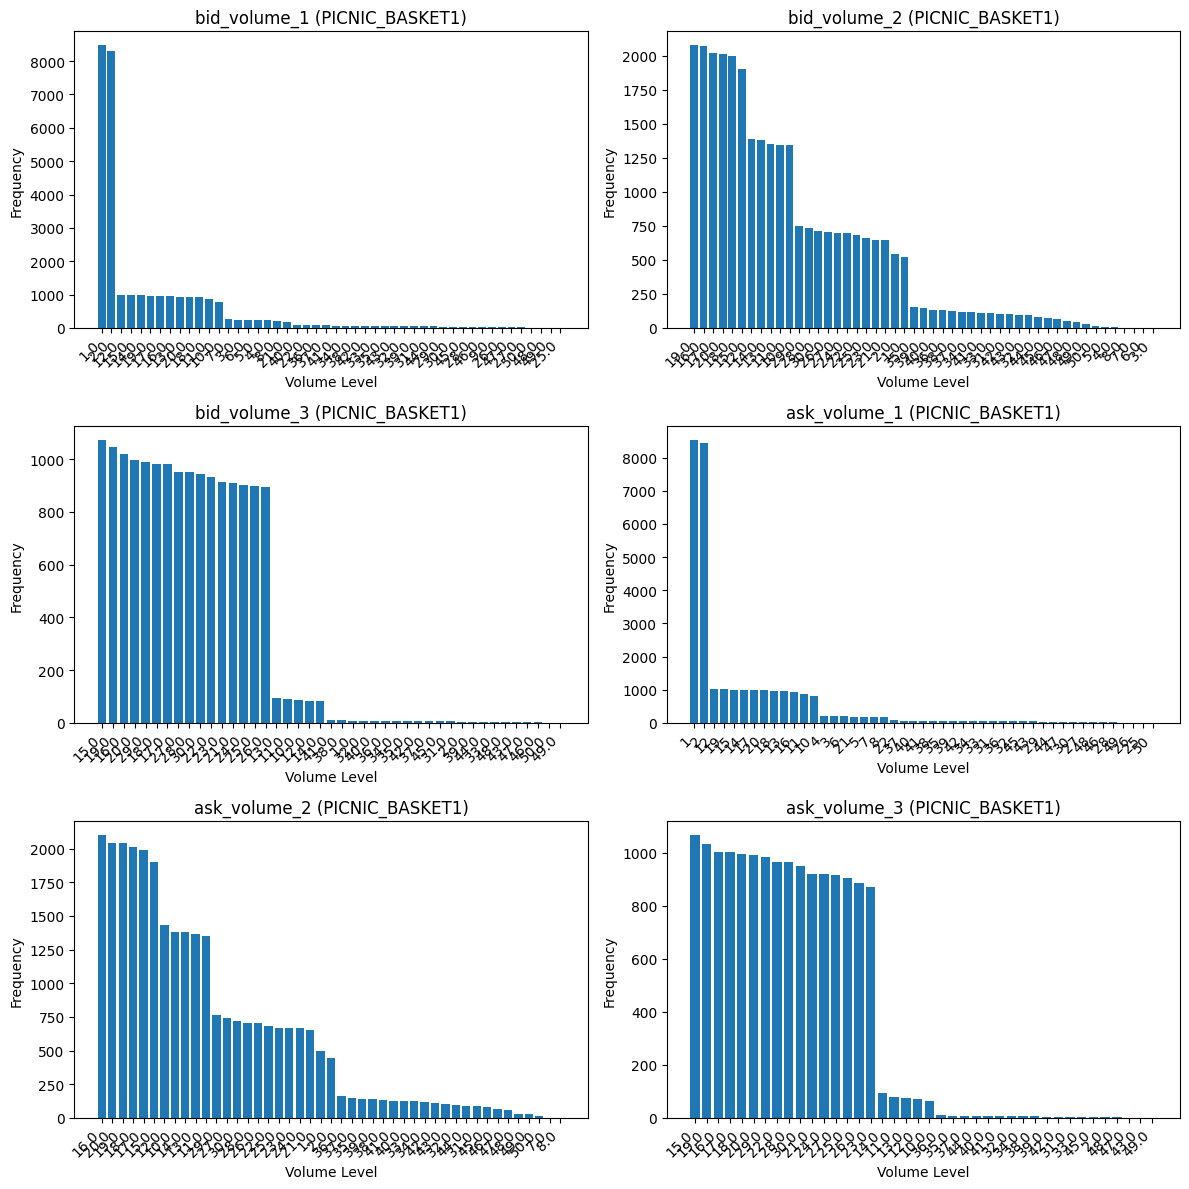

In [293]:
orderbook_histogram(orders_df, 'PICNIC_BASKET1')

In [294]:
PB1_composition = {'CROISSANTS': 6, 'JAMS': 3, 'DJEMBES': 1}
PB2_composition = {'CROISSANTS': 4, 'JAMS': 2}

price_pb1 = get_instrument_price_series(trades_df, 'PICNIC_BASKET1')
price_pb2 = get_instrument_price_series(trades_df, 'PICNIC_BASKET2')
price_croissants = get_instrument_price_series(trades_df, 'CROISSANTS')
price_jams = get_instrument_price_series(trades_df, 'JAMS')
price_djembes = get_instrument_price_series(trades_df, 'DJEMBES')

pb1adf = adfuller(price_pb1)
pb2adf = adfuller(price_pb2)
cadf = adfuller(price_croissants)
jadf = adfuller(price_jams)
dadf = adfuller(price_djembes)

--- Regression: PB1 ~ CROISSANTS + JAMS + DJEMBES Results ---
Dependent Variable (y): price
Independent Variables (X): CROISSANTS, JAMS, DJEMBES
Intercept: 39630.2076
Coefficients:
  CROISSANTS: 0.8869
  JAMS: 1.1386
  DJEMBES: 0.5892
R-squared: 0.0417
-------------------------------------------------------


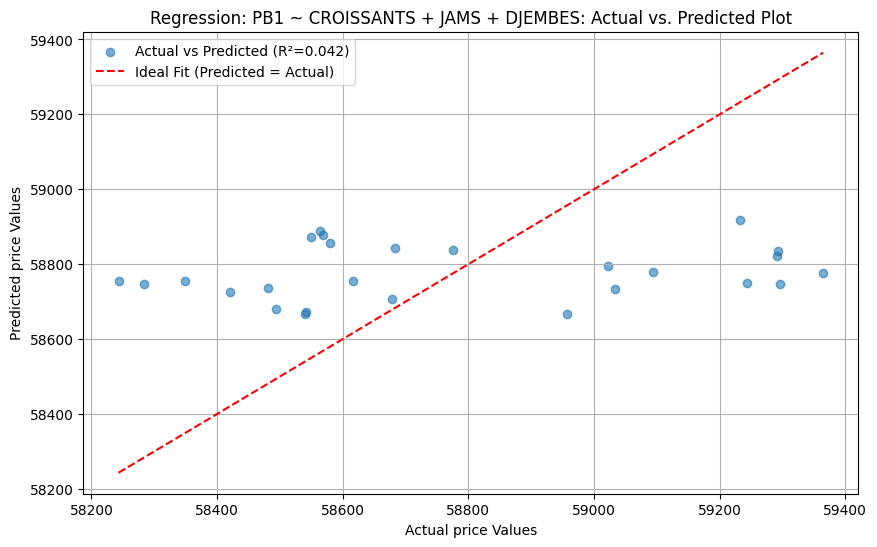

In [295]:
X_pb1_predictors = pd.DataFrame({
    'CROISSANTS': price_croissants,
    'JAMS': price_jams,
    'DJEMBES': price_djembes
})

model_fit_pb1 = multilinear_regression_analysis(
    X_df = X_pb1_predictors,
    y_series = price_pb1,  # The actual PB1 price series
    analysis_title = "Regression: PB1 ~ CROISSANTS + JAMS + DJEMBES"
)

timestamp
1000      492.143009
3500      315.801804
24100    -160.196805
101500   -308.186196
165600    549.028196
Name: PB1_Spread (Residuals), dtype: float64


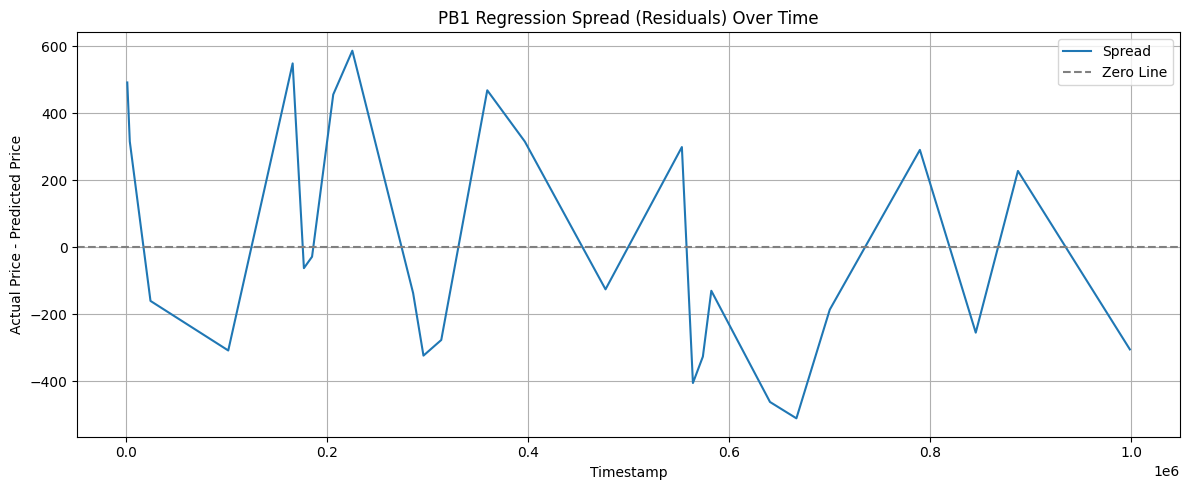

(-4.304651625212834, 0.0004360449897912398, 0, 25, {'1%': -3.7238633119999998, '5%': -2.98648896, '10%': -2.6328004}, 232.67584537703624)


In [296]:
aligned_data_pb1 = pd.concat([price_pb1, X_pb1_predictors], axis=1).dropna()
y1_aligned = aligned_data_pb1[price_pb1.name] 
X1_aligned = aligned_data_pb1[X_pb1_predictors.columns]
y1_predicted = model_fit_pb1.predict(X1_aligned)
spread_pb1 = pd.Series(y1_aligned - y1_predicted, index=aligned_data_pb1.index)
spread_pb1.name = 'PB1_Spread (Residuals)'
print(spread_pb1.head())

plt.figure(figsize=(12, 5))
spread_pb1.plot(title='PB1 Regression Spread (Residuals) Over Time', label='Spread') # Added label for clarity
plt.ylabel('Actual Price - Predicted Price')
plt.xlabel('Timestamp') # Add x-axis label
plt.axhline(0, color='grey', linestyle='--', label='Zero Line') # Added label
plt.grid(True)
plt.legend() 
plt.tight_layout() 
plt.show()

adf_result_pb1 = adfuller(spread_pb1.dropna())
print(adf_result_pb1)

--- Regression: PB2 ~ CROISSANTS + JAMS Results ---
Dependent Variable (y): price
Independent Variables (X): CROISSANTS, JAMS
Intercept: 24785.0953
Coefficients:
  CROISSANTS: 1.8618
  JAMS: -0.3857
R-squared: 0.0761
---------------------------------------------


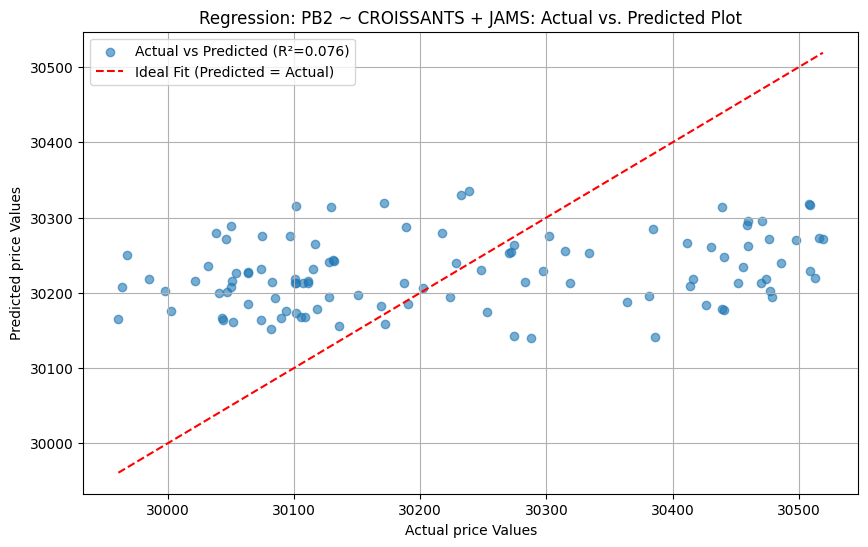

In [297]:
X_pb2_predictors = pd.DataFrame({
    'CROISSANTS': price_croissants,
    'JAMS': price_jams
})

model_fit_pb2 = multilinear_regression_analysis(
    X_df = X_pb2_predictors,
    y_series = price_pb2,  # The actual PB2 price series
    analysis_title = "Regression: PB2 ~ CROISSANTS + JAMS"
)

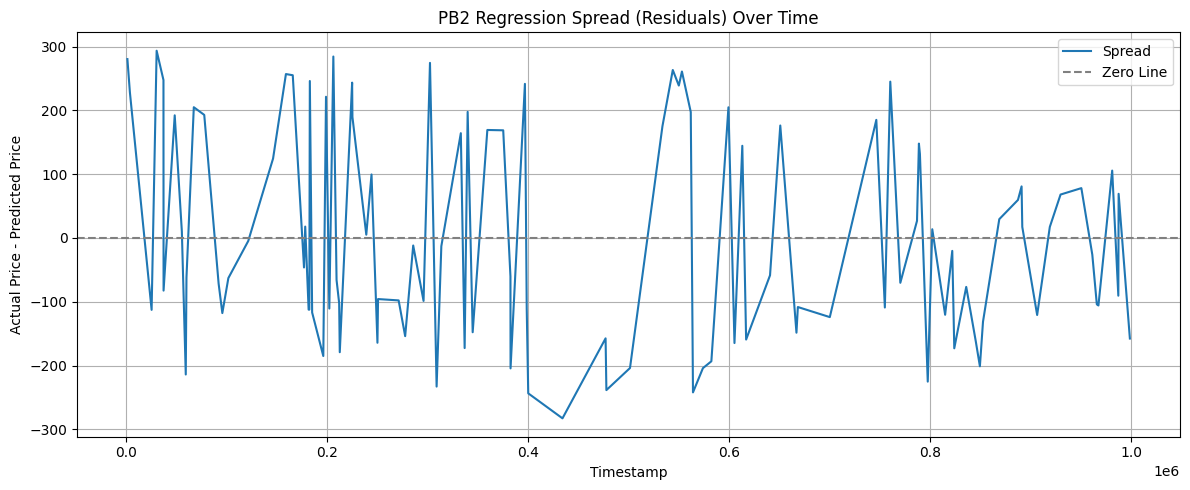

(-9.849015197034236, 4.538015518742433e-17, 0, 107, {'1%': -3.492995948509562, '5%': -2.888954648057252, '10%': -2.58139291903223}, 1223.7400890915471)


In [298]:
aligned_data_pb2 = pd.concat([price_pb2, X_pb2_predictors], axis=1).dropna()
y2_aligned = aligned_data_pb2[price_pb2.name] 
X2_aligned = aligned_data_pb2[X_pb2_predictors.columns]
y2_predicted = model_fit_pb2.predict(X2_aligned)
spread_pb2 = pd.Series(y2_aligned - y2_predicted, index=aligned_data_pb2.index)
spread_pb2.name = 'PB2_Spread (Residuals)'

plt.figure(figsize=(12, 5))
spread_pb2.plot(title='PB2 Regression Spread (Residuals) Over Time', label='Spread') # Added label for clarity
plt.ylabel('Actual Price - Predicted Price')
plt.xlabel('Timestamp') # Add x-axis label
plt.axhline(0, color='grey', linestyle='--', label='Zero Line') # Added label
plt.grid(True)
plt.legend() 
plt.tight_layout() 
plt.show()

adf_result_pb2 = adfuller(spread_pb2.dropna())
print(adf_result_pb2)

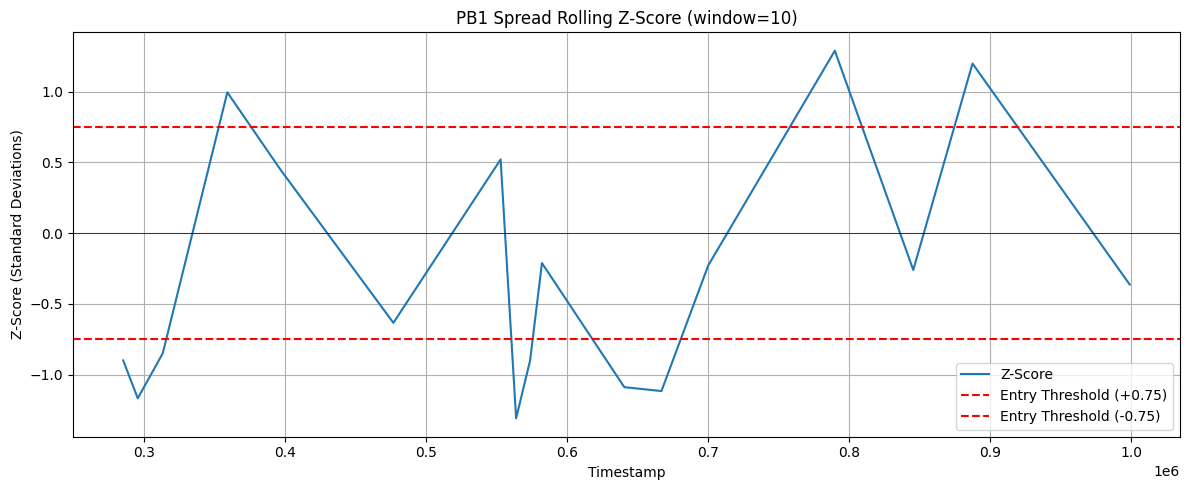

In [299]:
z_score_window = 10
zscore_pb1 = rolling_zscore(spread_pb1, window=z_score_window)
zscore_pb1.name = 'PB1_ZScore'
# zscore_pb1 = pd.Series(dtype=float)

plt.figure(figsize=(12, 5))
zscore_pb1.plot(title=f'PB1 Spread Rolling Z-Score (window={z_score_window})', label='Z-Score')
entry_threshold = 0.75
plt.axhline(entry_threshold, color='red', linestyle='--', label=f'Entry Threshold (+{entry_threshold})')
plt.axhline(-entry_threshold, color='red', linestyle='--', label=f'Entry Threshold (-{entry_threshold})')
plt.axhline(0, color='black', linestyle='-', linewidth=0.5) # Zero line
plt.ylabel('Z-Score (Standard Deviations)')
plt.xlabel('Timestamp')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

timestamp
1000           NaN
3500           NaN
25100          NaN
30100          NaN
36900          NaN
            ...   
967600   -1.267523
981300    1.218433
987400   -0.872979
987700    0.900382
998900   -1.511676
Name: PB2_ZScore, Length: 108, dtype: float64


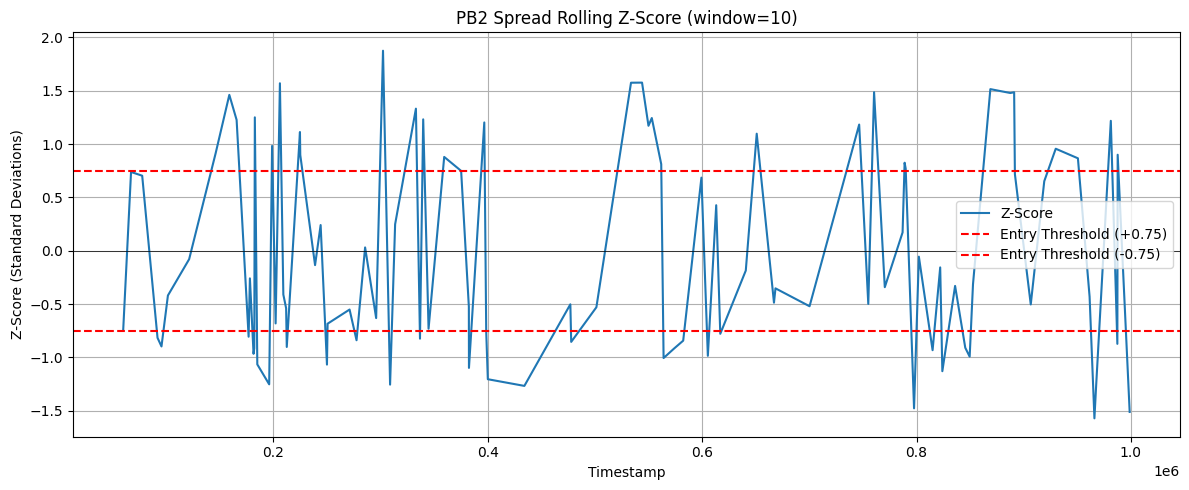

In [300]:
zscore_pb2 = rolling_zscore(spread_pb2, window=z_score_window)
zscore_pb2.name = 'PB2_ZScore'
print(zscore_pb2)
# zscore_pb2 = pd.Series(dtype=float)

plt.figure(figsize=(12, 5))
zscore_pb2.plot(title=f'PB2 Spread Rolling Z-Score (window={z_score_window})', label='Z-Score')
plt.axhline(entry_threshold, color='red', linestyle='--', label=f'Entry Threshold (+{entry_threshold})')
plt.axhline(-entry_threshold, color='red', linestyle='--', label=f'Entry Threshold (-{entry_threshold})')
plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
plt.ylabel('Z-Score (Standard Deviations)')
plt.xlabel('Timestamp')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [304]:
df_coint_pb1 = pd.DataFrame({
    'PICNIC_BASKET1': price_pb1, 
    'CROISSANTS': price_croissants,
    'JAMS': price_jams,
    'DJEMBES': price_djembes
}).dropna()

optimal_k_ar_diff_pb1 = 1
max_lags_to_test = 4
var_model_pb1 = VAR(df_coint_pb1)
lag_selection_results = var_model_pb1.select_order(maxlags=max_lags_to_test)
print(lag_selection_results.summary())
selected_orders = lag_selection_results.selected_orders

aic_lag = selected_orders.get('aic', 'N/A')
bic_lag = selected_orders.get('bic', 'N/A')
fpe_lag = selected_orders.get('fpe', 'N/A')
hqic_lag = selected_orders.get('hqic', 'N/A')

print(f"  AIC: {aic_lag}")
print(f"  BIC: {bic_lag}")
print(f"  FPE: {fpe_lag}")
print(f"  HQIC: {hqic_lag}")

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       33.35      33.55*   3.037e+14       33.39
1       33.26       34.25   2.878e+14       33.49
2       33.59       35.37   4.742e+14       34.01
3       33.24       35.82   5.534e+14       33.85
4      30.25*       33.63  1.055e+14*      31.05*
-------------------------------------------------
  AIC: 4
  BIC: 0
  FPE: 4
  HQIC: 4


/opt/anaconda3/envs/MainEnvironment/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [317]:
det_order = 0
k_ar_diff = 1
result_pb1 = coint_johansen(df_coint_pb1, det_order=det_order, k_ar_diff=k_ar_diff)

print(result_pb1.lr1)
print(result_pb1.cvt)
print(result_pb1.lr2)
print(result_pb1.cvm)
coint_vector = result_pb1.evec[:, 0]
coint_vector

[56.38943428 27.91865602 11.52299211  4.20418984]
[[44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
[28.47077826 16.39566391  7.31880227  4.20418984]
[[25.1236 27.5858 32.7172]
 [18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


array([ 0.00352512, -0.02029658, -0.00011732, -0.00973622])

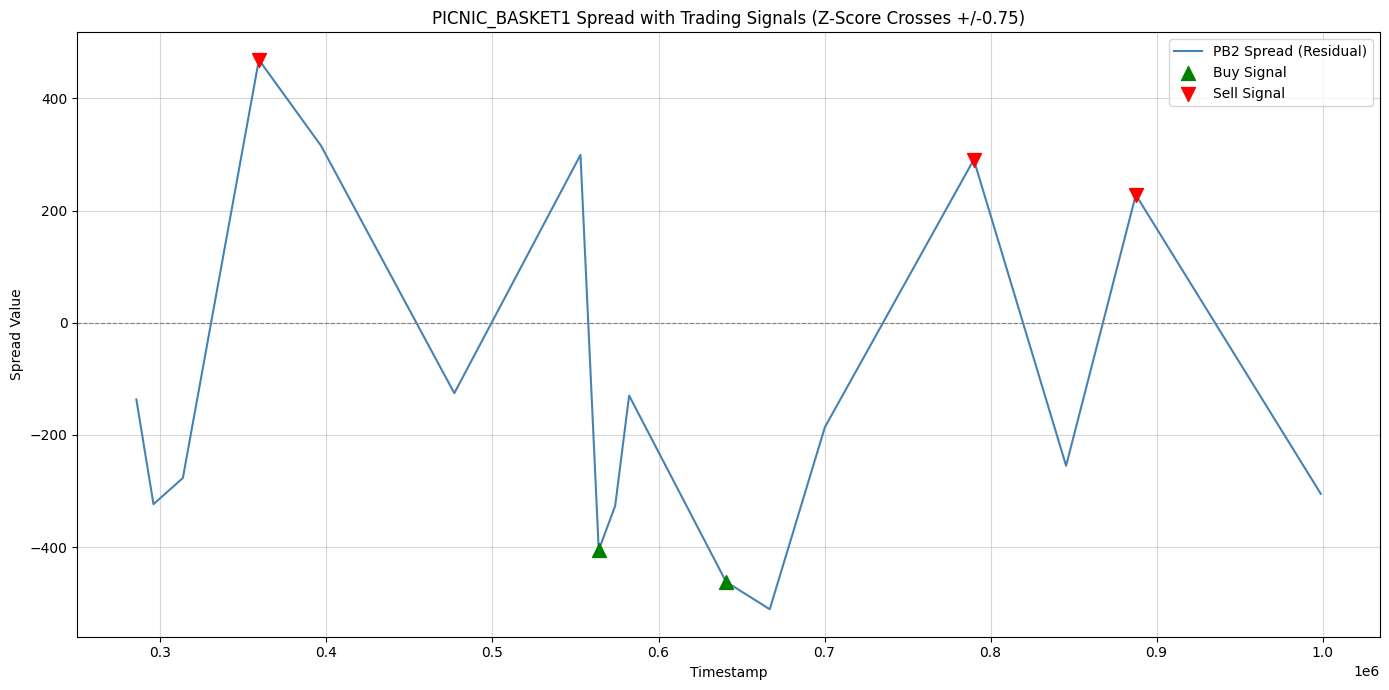

In [322]:
common_idx = spread_pb1.index.intersection(zscore_pb1.dropna().index)
spread_plot = spread_pb1.loc[common_idx]
zscore_plot = zscore_pb1.loc[common_idx]
buy_signal_points = (zscore_plot < -entry_threshold) & (zscore_plot.shift(1) >= -entry_threshold)
sell_signal_points = (zscore_plot > entry_threshold) & (zscore_plot.shift(1) <= entry_threshold)
buy_markers = spread_plot[buy_signal_points]
sell_markers = spread_plot[sell_signal_points]
plt.figure(figsize=(14, 7)) 

# Plot the spread series
plt.plot(spread_plot.index, spread_plot.values, label='PB2 Spread (Residual)', color='steelblue', linewidth=1.5)

# Plot Buy signals as green upward triangles
plt.scatter(buy_markers.index, buy_markers.values,
            marker='^', color='green', s=100, label='Buy Signal', zorder=5) # s=size, zorder=layering

# Plot Sell signals as red downward triangles
plt.scatter(sell_markers.index, sell_markers.values,
            marker='v', color='red', s=100, label='Sell Signal', zorder=5)

# Add plot elements
plt.title(f'PICNIC_BASKET1 Spread with Trading Signals (Z-Score Crosses +/-{entry_threshold})')
plt.xlabel('Timestamp')
plt.ylabel('Spread Value')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Zero line for reference
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

In [309]:
df_coint_pb2 = pd.DataFrame({
    'PICNIC_BASKET2': price_pb2, 
    'CROISSANTS': price_croissants,
    'JAMS': price_jams
}).dropna()

optimal_k_ar_diff_pb1 = 1
max_lags_to_test = 5
var_model_pb2 = VAR(df_coint_pb2)
lag_selection_results = var_model_pb2.select_order(maxlags=max_lags_to_test)
print(lag_selection_results.summary())
selected_orders = lag_selection_results.selected_orders

aic_lag = selected_orders.get('aic', 'N/A')
bic_lag = selected_orders.get('bic', 'N/A')
fpe_lag = selected_orders.get('fpe', 'N/A')
hqic_lag = selected_orders.get('hqic', 'N/A')

print(f"  AIC: {aic_lag}")
print(f"  BIC: {bic_lag}")
print(f"  FPE: {fpe_lag}")
print(f"  HQIC: {hqic_lag}")

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      24.00*      24.07*  2.636e+10*      24.03*
1       24.11       24.42   2.958e+10       24.23
2       24.06       24.59   2.803e+10       24.27
3       24.12       24.89   2.986e+10       24.43
4       24.09       25.08   2.898e+10       24.49
5       24.12       25.35   3.014e+10       24.62
-------------------------------------------------
  AIC: 0
  BIC: 0
  FPE: 0
  HQIC: 0


/opt/anaconda3/envs/MainEnvironment/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [318]:
det_order = 0
k_ar_diff = 1
result_pb2 = coint_johansen(df_coint_pb2, det_order=det_order, k_ar_diff=k_ar_diff)

print(result_pb2.lr1)
print(result_pb2.cvt)
print(result_pb2.lr2)
print(result_pb2.cvm)
coint_vector = result_pb2.evec[:, 0]
coint_vector

[113.45569604  59.82696068  24.14743479]
[[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
[53.62873536 35.67952588 24.14743479]
[[18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


array([ 0.00659157, -0.00360748, -0.02096642])

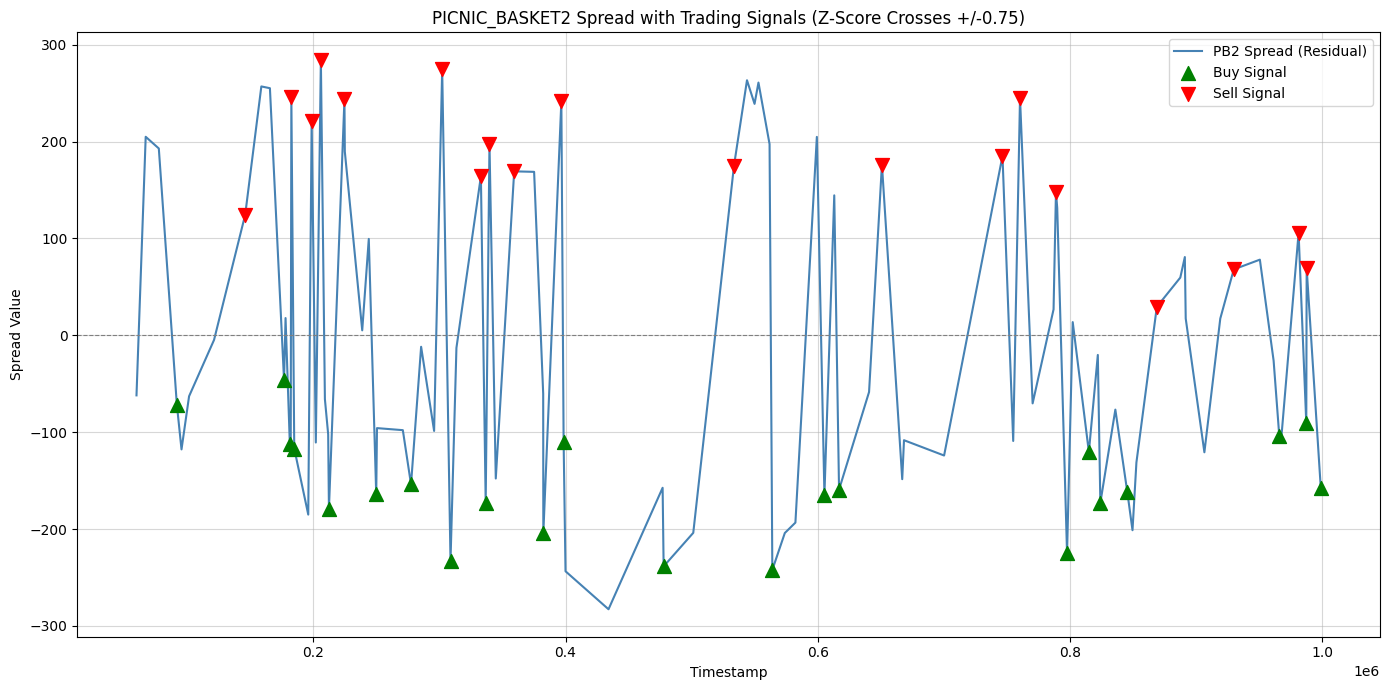

In [319]:
common_idx = spread_pb2.index.intersection(zscore_pb2.dropna().index)
spread_plot = spread_pb2.loc[common_idx]
zscore_plot = zscore_pb2.loc[common_idx]
buy_signal_points = (zscore_plot < -entry_threshold) & (zscore_plot.shift(1) >= -entry_threshold)
sell_signal_points = (zscore_plot > entry_threshold) & (zscore_plot.shift(1) <= entry_threshold)
buy_markers = spread_plot[buy_signal_points]
sell_markers = spread_plot[sell_signal_points]
plt.figure(figsize=(14, 7)) 

# Plot the spread series
plt.plot(spread_plot.index, spread_plot.values, label='PB2 Spread (Residual)', color='steelblue', linewidth=1.5)

# Plot Buy signals as green upward triangles
plt.scatter(buy_markers.index, buy_markers.values,
            marker='^', color='green', s=100, label='Buy Signal', zorder=5) # s=size, zorder=layering

# Plot Sell signals as red downward triangles
plt.scatter(sell_markers.index, sell_markers.values,
            marker='v', color='red', s=100, label='Sell Signal', zorder=5)

# Add plot elements
plt.title(f'PICNIC_BASKET2 Spread with Trading Signals (Z-Score Crosses +/-{entry_threshold})')
plt.xlabel('Timestamp')
plt.ylabel('Spread Value')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Zero line for reference
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()